# Séries temporais - Luizalabs

O objetivo desse projeto é explorar modelos de séries temporais.

Para isso, selecionei a categoria de produto mais pedido de uma base de dados de inventário. Assim, garantindo que existem dados suficientes para criar modelos de séries temporais consistentes.

O projeto é dividido em cinco tópicos:

1. Tratamento da base de dados
2. Modelos de séries temporais
3. Previsão e avaliação do modelo
4. Ajuste do modelo
5. Referências

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [120]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [121]:
inventory = pd.read_csv('desafio.csv', sep=',')
inventory.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


In [122]:
inventory['capture_date'] = pd.to_datetime(inventory['capture_date'])

In [123]:
categories_quantity = inventory.groupby('category').count().sort_values('order_id', ascending=False).reset_index()
categories_quantity.head()
df = inventory[(inventory['category'] == categories_quantity[(categories_quantity.index == 0)]['category'][0])]
df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
356,2b382c9769a8f6a564089928642c12c6,723f73c85e91fc31d147dfade389d4f9,1,404.91,37.4542,35.6329,0.0,388128822cef4b4f102ae881e040a64b,289.3563,em rota de entrega,2016-06-08,2016-06-09,processado,b76eb9b8fc0f17098812da9117d3e500
357,82134261102be216e336e8e36ea46cdb,723f73c85e91fc31d147dfade389d4f9,1,464.40,42.9570,54.4881,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,b76eb9b8fc0f17098812da9117d3e500
358,5a5b7a1c31f1fd87e8b74656f2822542,723f73c85e91fc31d147dfade389d4f9,1,404.91,37.4542,35.6329,0.0,388128822cef4b4f102ae881e040a64b,289.3563,em rota de entrega,2016-06-08,2016-06-10,processado,b76eb9b8fc0f17098812da9117d3e500
359,02f1253d9a6bd3792e7ac5ff187ff2ef,723f73c85e91fc31d147dfade389d4f9,1,449.90,41.6158,52.7868,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,98defd6ee70dfb1dea416cecdf391f58
360,ca7ae41d48db38b1b2c57f8567bfdfc1,723f73c85e91fc31d147dfade389d4f9,1,449.88,41.6139,0.0000,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,7261d300057219056592010c7bdaf5ee


In [124]:
df = df.groupby(['capture_date']).agg(sum_qtd=("quantity", "sum")).reset_index().sort_values('capture_date', ascending=True)
df.head()

,capture_date,sum_qtd
0,2016-06-01,210
1,2016-06-02,231
2,2016-06-03,293
3,2016-06-04,233
4,2016-06-05,210


# 1. Tratamento da base de dados

Nesse tópico, a base de dados foi preparada para a modelagem.

Primeiramente, foi plotado um gráfico da série temporal para verificar que visualmente a série não possui sazonalidades, tendências ou ciclos.

Para verificar o componente de sazonalidade, foi calculado o teste "Augmented Dickey-Fuller". Como o p-valor foi menor que 0,05, é possível concluir que a série não possui um componente de sazonalidade e já está estacionária para o modelo. Também mostra que um modelo ARIMA não-sazonal é mais adequado que um modelo SARIMA.

A próxima etapa, portanto, é avaliar quais seriam os melhores parâmetros para o modelo, seguindo a seguinte estrutura: ARIMA(p, d, q).

Para isso, gerou-se um gráfico ACF e um PACF. O lag-1 do gráfico ACF é uma autocorrelação positiva, mostrando que provavelmente o modelo seria melhor ajustado com uma autoregressão ao invés de uma média móvel. O comportamento dos gráficos ACF e PACF corroboram com essa indicação, já que no ACF os picos decaem gradualmente e no PACF os picos caem rapidamente depois do lag-2. Portanto, o modelo terá p>0 e q=0.
Para decidir o componente de autoregressão (p), usa-se o número de lags significativos nos gráficos ACF e PACF. No gráfico ACF, existem 3 lags significativos e no PACF, 2 lags significativos. Portanto, roda-se o modelo com p=3 e p=2.
Por fim, o componente d=0, já que não foi necessário calcular nenhuma diferenciação para tornar a série estacionária.

Portanto, roda-se dois modelos ARIMA no tópico 2.1:
ARIMA(3, 0, 0)
ARIMA(2, 0, 0)

Ainda que os parâmetros mostrem que o modelo será melhor ajustado com autoregressão, como o propósito do projeto é explorar modelos de séries temporais, também roda-se modelos baseados em média móvel no tópico 2.2.

Portanto, roda-se dois modelos ARIMA no tópico 2.2:
ARIMA(0, 0, 3)
ARIMA(0, 0, 2)

Antes de rodar os modelos, ainda divide-se a série em duas: uma para treino (75%) e uma para teste (25%).

In [125]:
sns.set(rc={'figure.figsize':(18, 10)})

<AxesSubplot:xlabel='capture_date'>

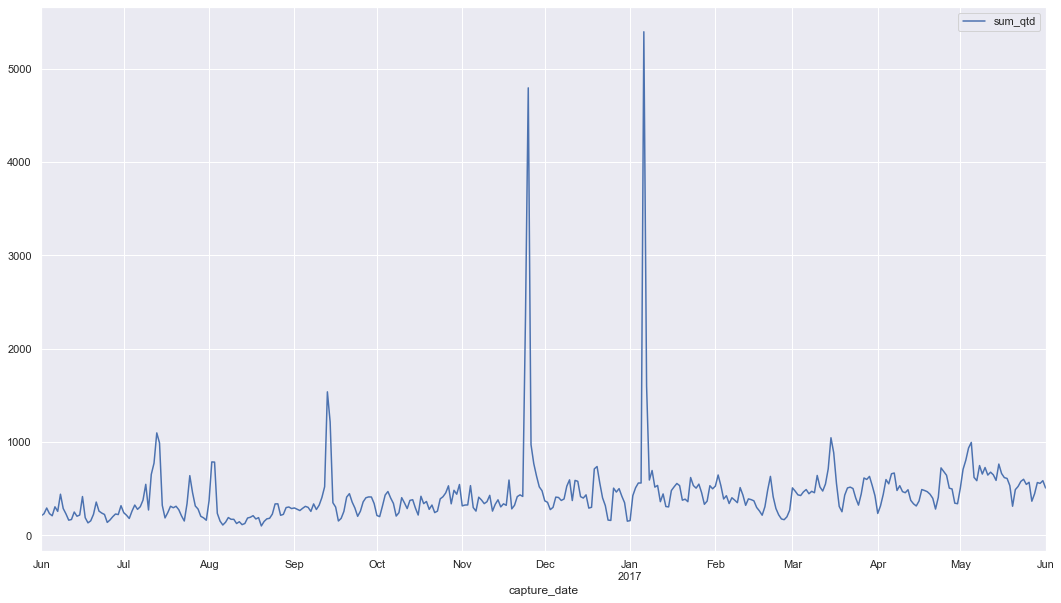

In [126]:
df.plot(x='capture_date', y='sum_qtd')

In [127]:
# O p-valor menor que 0.05 mostra que a série é estacionária, então não é preciso criar uma diferenciação
ad_fuller_result = adfuller(df['sum_qtd'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -12.03015028944039
p-value: 2.8867253790195387e-22


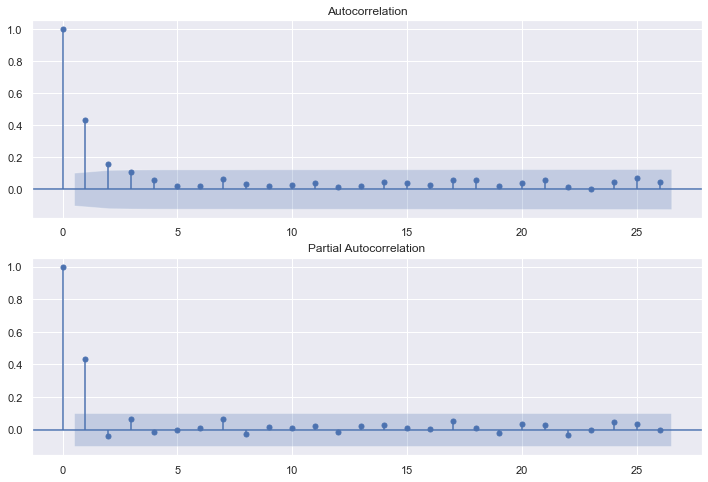

In [128]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['sum_qtd'].values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['sum_qtd'], ax=ax2)

In [129]:
df.index = df['capture_date']
df = df.drop(['capture_date'], axis=1)
train, test = train_test_split(df, train_size=0.75, shuffle=False)
print("train: ", train.shape)
print("test: ", test.shape)

train:  (274, 1)
test:  (92, 1)


# 2. Modelos de séries temporais

# 2.1 Autoregressão

Nesse tópico, roda-se dois modelos ARIMA autoregressivos: ARIMA(3, 0, 0) e ARIMA(2, 0, 0).

Ao observar os dois modelos, percebe-se que o índice AIC é um pouco melhor no modelo com p=2, portanto, esse será o modelo previsto e avaliado no tópico 3.

Ainda, calcula-se a equação da reta do modelo regressivo que apresentou melhor avaliação com a equação Yule-Walker.

In [13]:
mod1 = AutoReg(train, 3)
res1 = mod1.fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:                sum_qtd   No. Observations:                  274
Model:                     AutoReg(3)   Log Likelihood               -2023.279
Method:               Conditional MLE   S.D. of innovations            422.857
Date:                Tue, 26 Oct 2021   AIC                             12.131
Time:                        17:36:26   BIC                             12.197
Sample:                    06-04-2016   HQIC                            12.158
                         - 03-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    236.4507     40.208      5.881      0.000     157.644     315.257
sum_qtd.L1     0.4295      0.061      7.082      0.000       0.311       0.548
sum_qtd.L2    -0.0680      0.066     -1.031      0.3

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [14]:
# Tem o menor AIC, então vou testar esse no diagnóstico
mod2 = AutoReg(train, 2)
res2 = mod2.fit()
print(res2.summary())

                            AutoReg Model Results                             
Dep. Variable:                sum_qtd   No. Observations:                  274
Model:                     AutoReg(2)   Log Likelihood               -2030.791
Method:               Conditional MLE   S.D. of innovations            422.929
Date:                Tue, 26 Oct 2021   AIC                             12.124
Time:                        17:36:29   BIC                             12.177
Sample:                    06-03-2016   HQIC                            12.145
                         - 03-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    251.9899     37.148      6.783      0.000     179.181     324.798
sum_qtd.L1     0.4270      0.061      7.047      0.000       0.308       0.546
sum_qtd.L2    -0.0409      0.061     -0.676      0.4

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [15]:
rho, sigma = yule_walker(df['sum_qtd'], 2)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [-0.44787363  0.03807096]
sigma: 370.79044436450863


# 2.2 Média móvel

Como mencionado no tópico 1, apesar de o modelo claramente ser melhor representado com componentes de autoregressão, como o objetivo do projeto é explorar diferentes modelos, roda-se dois modelos ARIMA de média móvel: ARIMA(0, 0, 3) e ARIMA(0, 0, 2.)

Como esperado, os índices AIC dos modelos de média móvel são muito maiores que os dos modelos autoregressivos rodados. Portanto, apenas o modelo autoregressivo será tratado nos próximos tópicos.

In [16]:
mod3 = sm.tsa.arima.ARIMA(train, order=(0, 0, 3))
res3 = mod3.fit()
print(res3.summary())

                               SARIMAX Results                                
Dep. Variable:                sum_qtd   No. Observations:                  274
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -2044.675
Date:                Tue, 26 Oct 2021   AIC                           4099.350
Time:                        17:36:35   BIC                           4117.415
Sample:                    06-01-2016   HQIC                          4106.601
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        408.4489    122.223      3.342      0.001     168.895     648.002
ma.L1          0.4272      0.026     16.356      0.000       0.376       0.478
ma.L2          0.1097      0.082      1.334      0.1

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [17]:
mod3 = sm.tsa.arima.ARIMA(train, order=(0, 0, 2))
res3 = mod3.fit()
print(res3.summary())

                               SARIMAX Results                                
Dep. Variable:                sum_qtd   No. Observations:                  274
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -2045.305
Date:                Tue, 26 Oct 2021   AIC                           4098.611
Time:                        17:36:38   BIC                           4113.063
Sample:                    06-01-2016   HQIC                          4104.412
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        408.4381    105.507      3.871      0.000     201.648     615.228
ma.L1          0.4268      0.025     17.215      0.000       0.378       0.475
ma.L2          0.0850      0.065      1.302      0.1

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


# 3. Previsão e avaliação de modelos

Os modelos ARIMA(2, 0, 0) ARIMA(3, 0, 0) e foram selecionados para passar pelas fases de previsão e avaliação.

A avaliação do modelo mostra que um dos lags de autocorrelação ainda não estão no intervalo devido. Além disso, o plot de resíduos mostra que estão bem diferentes entre si, o que pode apontar para uma tendência no modelo. Talvez, fosse interessante criar uma primeira diferenciação da base antes de rodar o modelo.

Foram previstos valores para a série temporal. E então, os valores previstos foram comparados com os valores da série de teste no cálculo dos coeficientes de erro: RMSE, MAE, MAPE.

Os dois modelos tem índices de erro muito similares e os gráficos de diagnóstico mostram que ainda podem ser aprimorados. Como o índice de AIC do modelo ARIMA(2, 0, 0) é menor que o do modelo ARIMA(3, 0, 0), os ajustes serão feitos nesse primeiro modelo.

# 3.1 ARIMA(2, 0, 0)

<Figure size 1080x864 with 0 Axes>

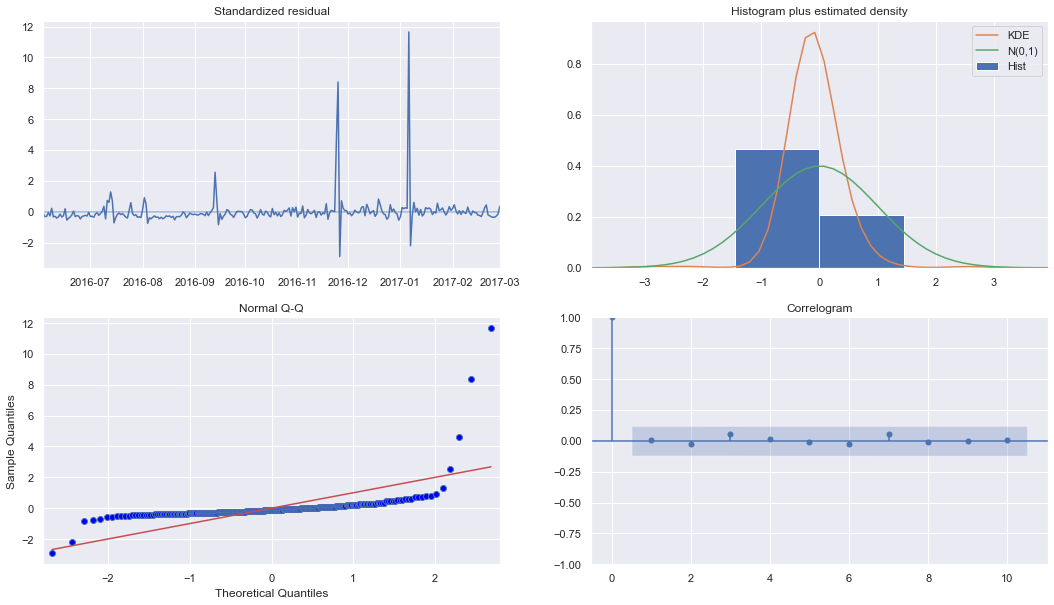

<Figure size 1080x864 with 0 Axes>

In [18]:
res2.plot_diagnostics()
plt.figure(figsize=(15, 12))

In [19]:
forecast = res2.forecast(92)

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


In [20]:
rmse = sqrt(mean_squared_error(test, forecast))
rmse

197.00181170657189

In [21]:
mae = mean_absolute_error(test, forecast)
mae

152.02228418323165

In [22]:
mape = mean_absolute_percentage_error(test, forecast)
mape

0.2600561901969606

# 3.2 ARIMA(3, 0, 0)

<Figure size 1080x864 with 0 Axes>

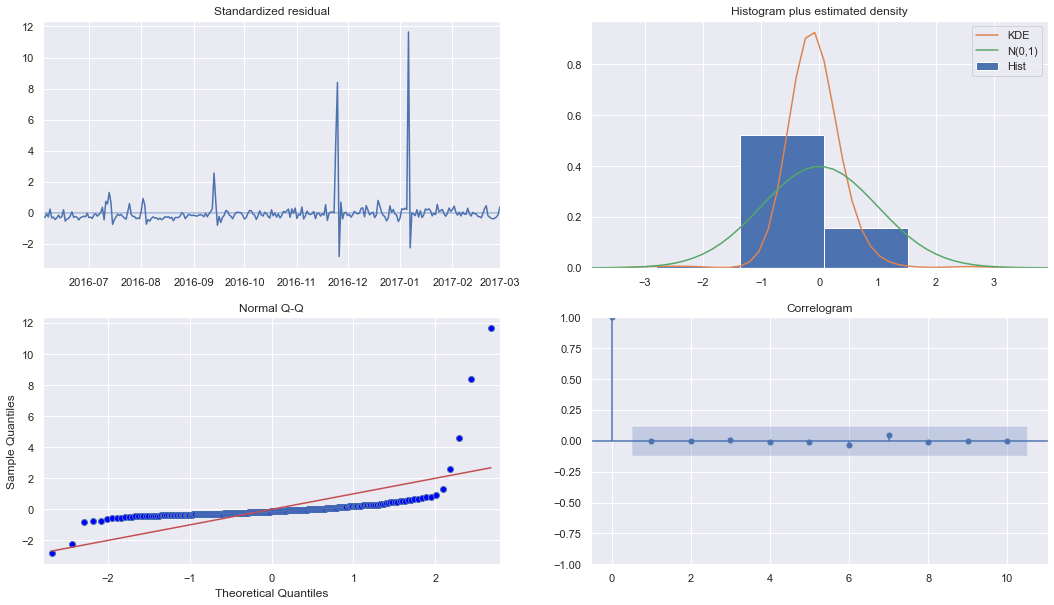

<Figure size 1080x864 with 0 Axes>

In [23]:
res1.plot_diagnostics()
plt.figure(figsize=(15, 12))

In [24]:
forecast1 = res1.forecast(92)

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


In [25]:
rmse = sqrt(mean_squared_error(test, forecast1))
rmse

196.76585023137676

In [26]:
mae = mean_absolute_error(test, forecast1)
mae

152.0066610955735

In [27]:
mape = mean_absolute_percentage_error(test, forecast)
mape

0.2600561901969606

# 4. Ajuste do modelo

A avaliação do modelo ARIMA(2, 0, 0) acima mostra que o modelo pode ser aprimorado. O gráfico de resíduos mostra outliers provenientes de picos de venda da "Semana do Consumidor" (setembro), "Black Friday" (novembro) e da "Liquidação Fantátistica do Magazine Luiza" (janeiro). Esses pontos estão enviesando o modelo, como pode ser visto no gráfico Q-Q, em que os pontos previstos não estão seguindo a reta desejada. Por isso, é preciso tratar desses outliers para rodar um modelo de maior acurácia.

Para isso, a quantidade de venda desses dias promocionais foi substituída por uma média das vendas os cinco dias anteriores, ou seja:

1. Semana do Consumidor: quantidades vendidas em 13 e 14 de setembro foram substituídas pela média de quantidades vendidas entre 08 e 12 de setembro
2. Black Friday: quantidades vendidas em 24 e 25 de novembro foram substituídas pela média de quantidades vendidas entre 19 e 23 de novembro
3. Liquidação Fantátistica do Magazine Luiza -> quantidades vendidas em 6 e 7 de janeiro foram substituídas pela média de quantidades vendidas entre 01 e 05 de janeiro

O índice AIC do modelo ajustado apresentou uma queda considerável, passando de 12,12 para 9,53.
O gráfico de resíduos apresenta um modelo com menr variância, o gráfico Q-Q mostra que os valores previstos estão muito mais alinhados com a reta da série temporal e o histograma apresenta uma curva normal. Todos esses resultados indicam que o modelo está bem ajustado.

Porém, os cálculos de erro estão um pouco maiores que os do modelo anterior, ou seja, as previsões o modelo preditivo ainda podem ser aprimorado, apesar de representar melhor os dados da série temporal.

In [102]:
df.loc['2016-09-08':'2016-09-14']

,sum_qtd
capture_date,
2016-09-08,337
2016-09-09,277
2016-09-10,323
2016-09-11,405
2016-09-12,521
2016-09-13,1538
2016-09-14,1216


In [103]:
df.loc['2016-11-19':'2016-11-26']

,sum_qtd
capture_date,
2016-11-19,284
2016-11-20,322
2016-11-21,415
2016-11-22,434
2016-11-23,417
2016-11-24,2356
2016-11-25,4795
2016-11-26,972


In [104]:
df.filter(like = '2017-01', axis=0).head(7)

,sum_qtd
capture_date,
2017-01-01,158
2017-01-02,426
2017-01-03,510
2017-01-04,561
2017-01-05,561
2017-01-06,5396
2017-01-07,1599


In [105]:
set_mean = df.loc['2016-09-08':'2016-09-12'].mean()
set_mean

sum_qtd    372.6
dtype: float64

In [130]:
nov_mean = df.loc['2016-11-19':'2016-11-23'].mean()
nov_mean

sum_qtd    374.4
dtype: float64

In [131]:
jan_mean = df.loc['2017-01-01':'2017-01-05'].mean()
jan_mean

sum_qtd    443.2
dtype: float64

In [108]:
df.loc['2016-09-13':'2016-09-14'] = int(set_mean)

In [132]:
df.loc['2016-11-24':'2016-11-25'] = int(nov_mean)

In [133]:
df.loc['2017-01-06':'2017-01-07'] = int(jan_mean)

In [134]:
train, test = train_test_split(df, train_size=0.75, shuffle=False)
print("train: ", train.shape)
print("test: ", test.shape)

train:  (274, 1)
test:  (92, 1)


In [135]:
adjmod = AutoReg(train, 2)
adjres = adjmod.fit()
print(adjres.summary())

                            AutoReg Model Results                             
Dep. Variable:                sum_qtd   No. Observations:                  274
Model:                     AutoReg(2)   Log Likelihood               -1720.184
Method:               Conditional MLE   S.D. of innovations            134.999
Date:                Tue, 26 Oct 2021   AIC                              9.840
Time:                        18:52:37   BIC                              9.893
Sample:                    06-03-2016   HQIC                             9.861
                         - 03-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    163.4872     20.055      8.152      0.000     124.179     202.795
sum_qtd.L1     0.7785      0.059     13.128      0.000       0.662       0.895
sum_qtd.L2    -0.2264      0.059     -3.822      0.0

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


<Figure size 1080x864 with 0 Axes>

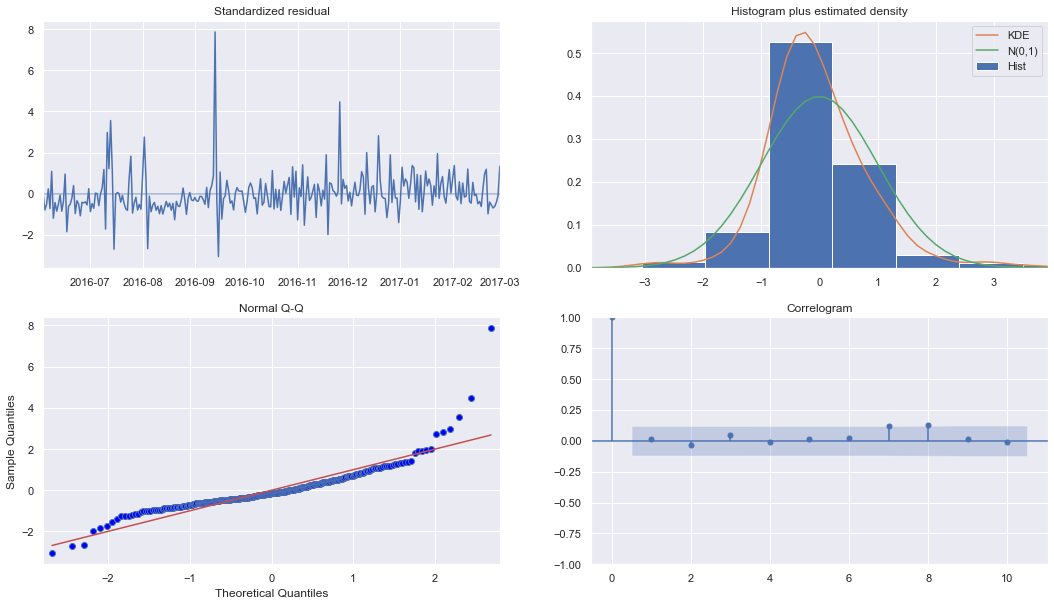

<Figure size 1080x864 with 0 Axes>

In [136]:
adjres.plot_diagnostics()
plt.figure(figsize=(15, 12))

In [137]:
adjforecast = adjres.forecast(92)

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


In [138]:
rmse = sqrt(mean_squared_error(test, adjforecast))
rmse

228.195636011931

In [139]:
mae = mean_absolute_error(test, adjforecast)
mae

182.26034228332074

In [140]:
mape = mean_absolute_percentage_error(test, adjforecast)
mape

0.30512853218406344

# 5. Referências

https://towardsdatascience.com/moving-averages-in-python-16170e20f6c
https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_arma_0.html
https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
